In [70]:
import ants
import numpy as np
from dipy.tracking.streamline import *
from dipy.io.streamline import *
from dipy.tracking.utils import *
from scipy.io import loadmat, savemat
import nibabel as nib
import nibabel.streamlines as nis
import matplotlib.pyplot as plt
from dipy.tracking.metrics import *

In [8]:
file = '/Users/mahdi/stage-2022-mahdi/niftis/tracts/avgt_wildtype_tractogram.trk'
streamlines, hdr = load_tractogram(filename=file)

## Fiber lengths histogram

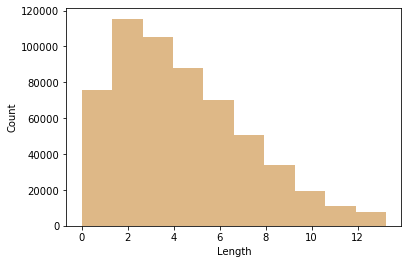

In [9]:
lengths = list(length(streamlines))

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='burlywood')
ax.set_xlabel('Length')
ax.set_ylabel('Count')
plt.show()

## Fiber from a ROI mask

In [13]:
roi_file = "/Users/mahdi/stage-2022-mahdi/niftis/485847695_180403712_25_0.07/485847695_180403712_x-rois_mask_25_0.07.nii.gz"
mask = nib.load(roi_file)

In [14]:
nearby_roi = near_roi(
    streamlines=streamlines,
    affine=mask.affine,
    region_of_interest=mask.get_fdata()
    )

In [15]:
print(nearby_roi.shape)

(577555,)


In [25]:
streamlines_near_roi = []
for i in range(len(streamlines)):
    if nearby_roi[i]:
        streamlines_near_roi.append(streamlines[i])   


In [30]:
save_tractogram(
    fname="/Users/mahdi/stage-2022-mahdi/niftis/tracts/near_roi.trk",
    streamlines=streamlines_near_roi,
    affine=np.eye(4)
    )

## Fiber from sphere and radius (entry coords)

In [76]:
def draw_spherical_mask(shape, radius, center):
    """
    Generate an n-dimensional spherical mask.

    Parameters
    ----------
    shape: tuple
        Shape of the volume created.
    radius: int/float
        Radius of the spherical mask.
    center: tuple
        Position of the center of the spherical mask.

    Return
    ------
    ndarray: Volume containing the spherical mask.
    """
    # Assuming shape and center have the same length and contain ints
    # (the units are pixels / voxels (px for short),
    # radius is a int or float in px)
    assert len(center) == len(shape)
    semisizes = (radius,) * len(shape)

    # Generating the grid for the support points
    # centered at the position indicated by center
    grid = [slice(-x0, dim - x0) for x0, dim in zip(center, shape)]
    center = np.ogrid[grid]

    # Calculating the distance of all points from center
    # scaled by the radius
    vol = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(center, semisizes):
        vol += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return vol <= 1.0

In [94]:
sphere = draw_spherical_mask(
    shape=mask.shape,
    radius=1,
    center=(68, 128, 66)
).astype(np.float32)

In [95]:
through_sphere = near_roi(
    streamlines=streamlines,
    affine=mask.affine,
    region_of_interest=sphere
    )

In [96]:
print(through_sphere.shape)

(577555,)


In [100]:
streamlines_in_sphere = []
for i in range(len(streamlines)):
    if through_sphere[i]:
        streamlines_in_sphere.append(streamlines[i])   

In [101]:
save_tractogram(
    fname="/Users/mahdi/stage-2022-mahdi/niftis/tracts/in_sphere.trk",
    streamlines=streamlines_in_sphere,
    affine=np.eye(4)
    )

## Orientation inside roi

In [69]:
print(mean_orientation(streamlines_near_roi[0]))

[ 0.05918167  0.05097019  0.01013423]
